In [1]:
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split


images_path = '/content/drive/MyDrive/RETOECHO/images.npy'
heatmaps_path = '/content/drive/MyDrive/RETOECHO/EQUAL7Kheatmaps.npy'

images = np.load(images_path)
heatmaps = np.load(heatmaps_path)

images= images[:7000]

We get the 200 Test images

In [2]:
images = images.astype('float32')
heatmaps = heatmaps.astype('float32')

images = images / 255.0

train_images, valid_images, train_heatmaps, valid_heatmaps = train_test_split(
    images, heatmaps, test_size=0.4, random_state=42
)
train_heatmaps = np.transpose(train_heatmaps, (0, 2, 3, 1))
valid_heatmaps = np.transpose(valid_heatmaps, (0, 2, 3, 1))

valid_images, test_images, valid_heatmaps, test_heatmaps = train_test_split(
    valid_images, valid_heatmaps, test_size=0.07142857142857142, random_state=42
)

print("valid images shape:", valid_images.shape)
print("valid heatmaps shape:", valid_heatmaps.shape)
print("test images shape:", test_images.shape)
print("test heatmaps shape:", test_heatmaps.shape)


valid images shape: (2600, 112, 112, 3)
valid heatmaps shape: (2600, 112, 112, 6)
test images shape: (200, 112, 112, 3)
test heatmaps shape: (200, 112, 112, 6)


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

def dice_coefficient(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    return (2.0 * intersection + 1e-15) / (union + 1e-15)

In [20]:
model = load_model('/content/Unet_model_FINAL.h5', custom_objects={'dice_coefficient': dice_coefficient})

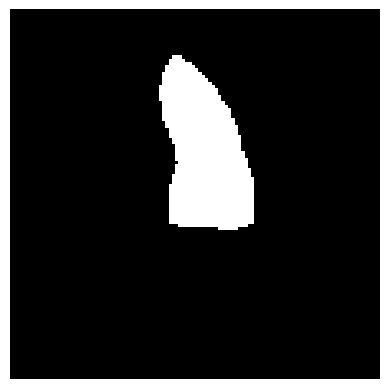

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def find_inner_point(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        return (cx, cy)
    else:
        return None

def fill_contours(mask):
    filled_mask = mask.copy()
    inner_point = find_inner_point(mask)
    if inner_point is not None:
        h, w = mask.shape
        flood_fill_mask = np.zeros((h + 2, w + 2), np.uint8)
        cv2.floodFill(filled_mask, flood_fill_mask, inner_point, 255)
    return filled_mask

def create_mask_from_heatmaps(heatmaps, percentile=95):
    mask = np.zeros_like(heatmaps[..., 0], dtype=np.uint8)
    priority_indices = [0, 1, 2, 3]

    for i in priority_indices:
        thresholded = heatmaps[..., i] > np.percentile(heatmaps[..., i], percentile)
        mask[thresholded] = 255

    for i in range(4, heatmaps.shape[-1]):
        thresholded = heatmaps[..., i] > np.percentile(heatmaps[..., i], percentile)
        mask[thresholded] = 255

    filled_mask = fill_contours(mask)
    return filled_mask


# Visualization code
index = np.random.randint(0, len(valid_images))
image = valid_images[index]
heatmaps = valid_heatmaps[index]

# Create masks
filled_mask = create_mask_from_heatmaps(heatmaps)
plt.imshow(filled_mask, cmap='gray')
plt.axis('off')  # to hide the axis labels
plt.show()

In [22]:
def extract_probability_line(heatmap, percentile=99):
    thresholded = heatmap > np.percentile(heatmap, percentile)
    return np.argwhere(thresholded)

def find_intersections(left_probability_line, right_probability_line, horizontal_line_y, central_x):
    combined_probability_line = np.concatenate((left_probability_line, right_probability_line), axis=0)

    points_on_line = combined_probability_line[combined_probability_line[:, 0] == horizontal_line_y, :]

    left_points = points_on_line[points_on_line[:, 1] < central_x]
    right_points = points_on_line[points_on_line[:, 1] >= central_x]

    avg_left_point = np.mean(left_points, axis=0) if len(left_points) > 0 else None
    avg_right_point = np.mean(right_points, axis=0) if len(right_points) > 0 else None

    return avg_left_point, avg_right_point


def sort_points_clockwise(points):
    centroid_x, centroid_y = calculate_centroid(points)
    return sorted(points, key=lambda p: (np.arctan2(p[1] - centroid_y, p[0] - centroid_x), p[0]))

def extract_landmarks(heatmap):
    return np.unravel_index(np.argmax(heatmap), heatmap.shape)

def calculate_centroid(points):
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    centroid_x = sum(x_coords) / len(points)
    centroid_y = sum(y_coords) / len(points)
    return (centroid_x, centroid_y)

def is_point_on_probability_line(avg_point, probability_line, horizontal_line_y):
    points_on_line = probability_line[probability_line[:, 0] == horizontal_line_y, :]
    return any(avg_point[1] == point[1] for point in points_on_line)

1/1 [==============================] - 1s 641ms/step


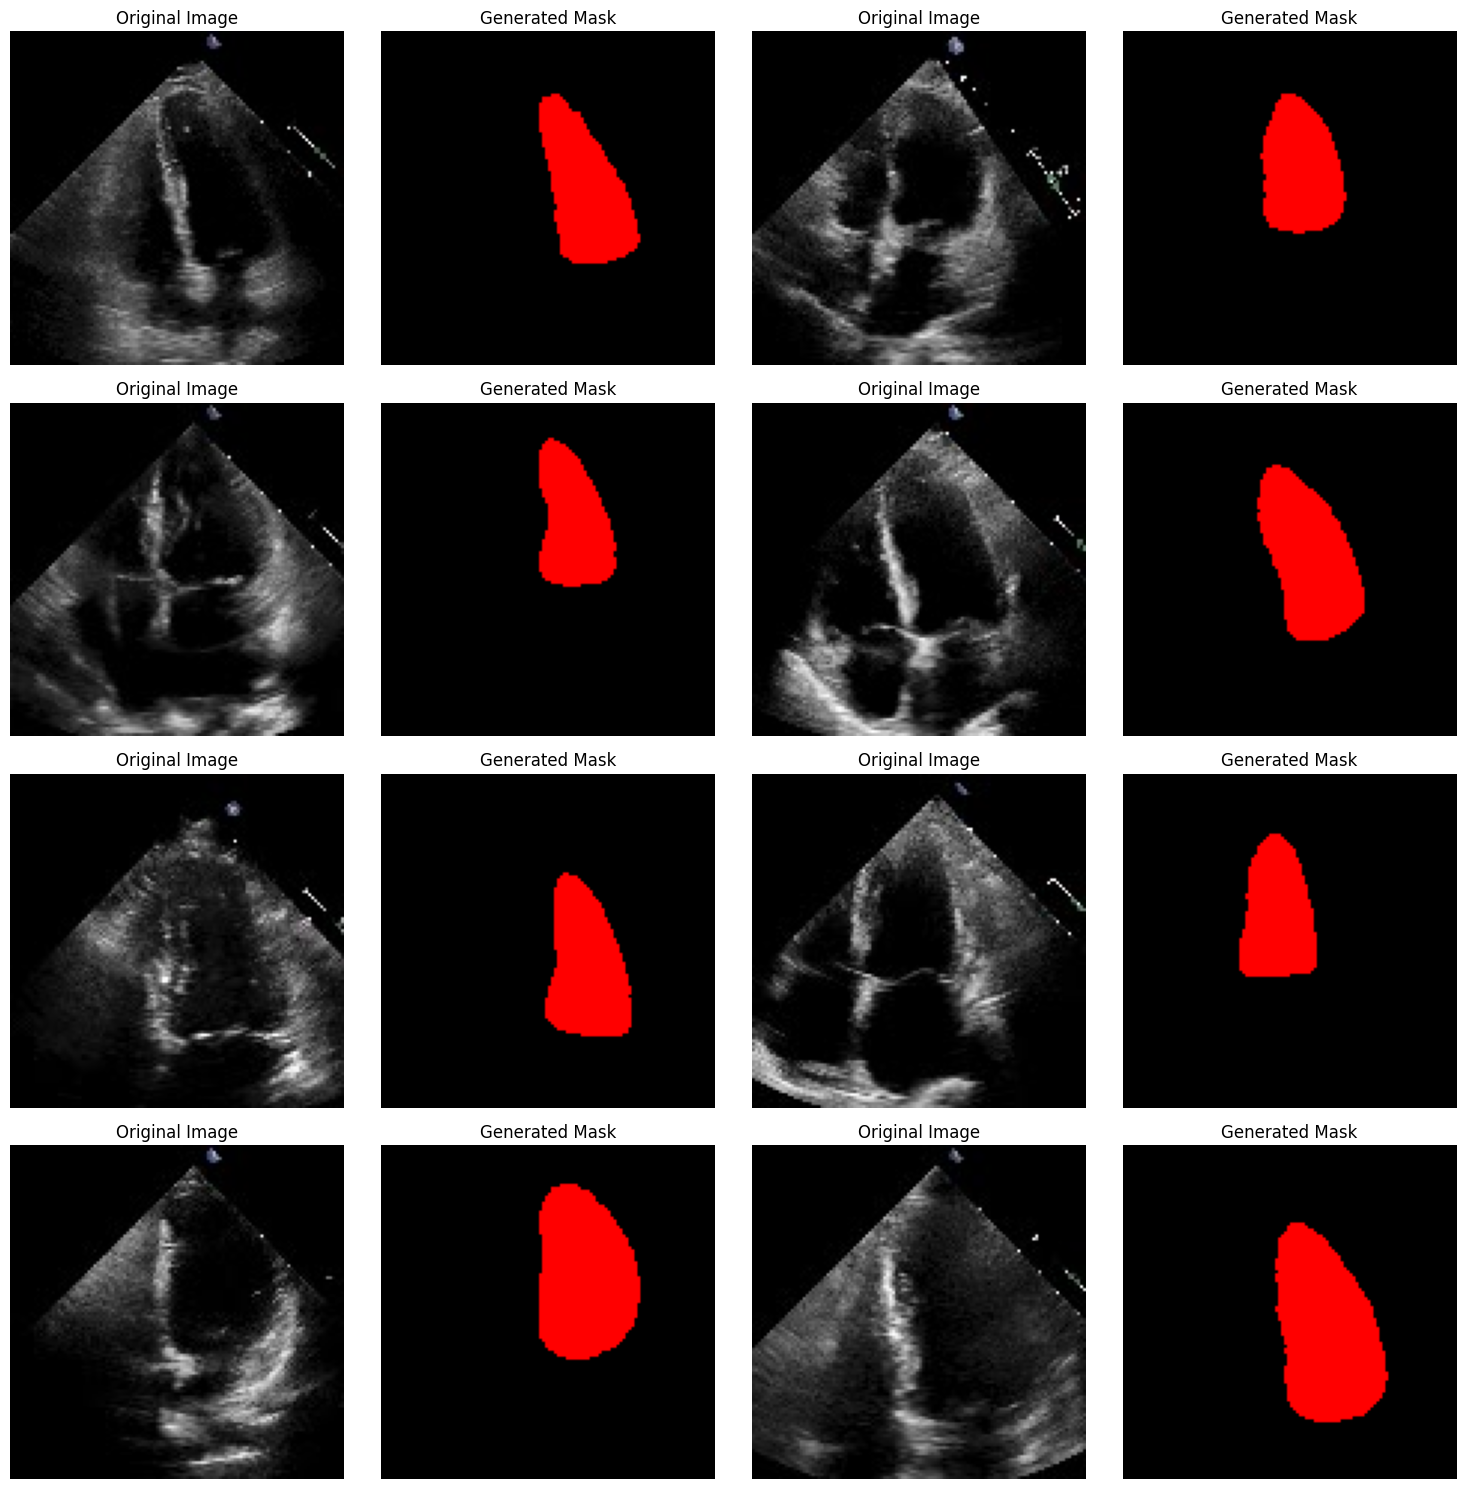

In [27]:
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
import cv2

def overlay_mask_on_image(image, mask, landmarks):
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if len(image.shape) == 3 and image.shape[2] == 3:
        mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    else:
        mask_color = mask

    mask_color = mask_color.astype(image.dtype)

    overlayed_image = cv2.addWeighted(image, 1, mask_color, 0.6, 0)

    for landmark in landmarks:
        if landmark is not None:
            x, y = int(landmark[1]), int(landmark[0])
            cv2.circle(overlayed_image, (x, y), 1, (0, 255, 0), -1)

    return overlayed_image

def process_image_and_generate_mask(image, heatmaps):
    top_landmark = extract_landmarks(heatmaps[..., 0])
    bottom_landmark = extract_landmarks(heatmaps[..., 1])
    bottom_left_landmark = extract_landmarks(heatmaps[..., 2])
    bottom_right_landmark = extract_landmarks(heatmaps[..., 3])

    central_bottom_point = calculate_centroid([bottom_landmark, bottom_left_landmark, bottom_right_landmark])

    left_probability_line = extract_probability_line(heatmaps[..., -2])
    right_probability_line = extract_probability_line(heatmaps[..., -1])

    horizontal_line_ys = np.linspace(top_landmark[0], central_bottom_point[0], 20)[1:-1].astype(int)
    central_x = (top_landmark[1] + central_bottom_point[1]) / 2

    landmarks = [top_landmark, bottom_landmark, bottom_left_landmark, bottom_right_landmark]

    for y in horizontal_line_ys:
        avg_left_intersection, avg_right_intersection = find_intersections(left_probability_line, right_probability_line, y, central_x=central_x)

        if avg_left_intersection is not None:
            landmarks.append(avg_left_intersection)

        if avg_right_intersection is not None:
            landmarks.append(avg_right_intersection)

    sorted_landmarks = sort_points_clockwise(landmarks)

    mask = draw_mask_from_landmarks(image, sorted_landmarks)

    return mask

def draw_mask_from_landmarks(image, landmarks, smooth_factor=.01):
    if len(landmarks) < 3:
        print("Not enough points for mask generation.")
        return None

    try:
        landmarks = [(y, x) for (x, y) in landmarks]
        sorted_landmarks = np.array(landmarks).T
        tck, u = splprep(sorted_landmarks, s=smooth_factor, per=True)
        new_points = splev(np.linspace(0, 1, 100), tck)
        points = np.array(new_points).T.astype(np.int32)

    except Exception as e:
        print(f"Error in spline fitting, using line drawing method: {e}")
        return None

    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.fillPoly(mask, [points], 255)
    return mask



random_indices = np.random.choice(len(test_images), 8, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    image = valid_images[idx]
    heatmaps = model.predict(np.expand_dims(image, axis=0))[0]

    mask = process_image_and_generate_mask(image, heatmaps)

    ax_orig = axes[i*2]
    ax_orig.imshow(image)
    ax_orig.set_title('Original Image')
    ax_orig.axis('off')

    ax_mask = axes[i*2 + 1]
    ax_mask.imshow(mask, cmap='gray')
    ax_mask.set_title('Generated Mask')
    ax_mask.axis('off')

plt.tight_layout()
plt.show()


In [25]:
raw_prediction = model.predict(np.expand_dims(image, axis=0))[0]
print("Raw prediction value range:", (np.min(raw_prediction), np.max(raw_prediction)))


1/1 [==============================] - 1s 606ms/step
Raw prediction value range: (0.0, 0.80619246)


In [ ]:
import numpy as np
import tensorflow as tf

def normalize_pred_mask(mask):
    max_val = np.max(mask)
    if max_val > 0:
        return mask / max_val  # Normalize to the range of 0 to 1
    return mask

def normalize_mask(mask, threshold=0.5):
    mask_binary = np.where(mask > threshold, 1, 0)
    return mask_binary

def ensure_single_channel(mask):
    # If the mask has more than one channel, convert it to grayscale
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return mask

def dice_coefficient(y_true, y_pred):
    print("y_true shape:", y_true.shape, "Value range:", (np.min(y_true), np.max(y_true)))
    print("y_pred shape:", y_pred.shape, "Value range:", (np.min(y_pred), np.max(y_pred)))

    y_true_flat = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_flat = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    return (2.0 * intersection + 1e-15) / (union + 1e-15)

# Step 1: Generate Ground Truth Masks
ground_truth_masks = [create_mask_from_heatmaps(heatmap) for heatmap in valid_heatmaps]

# Step 2: Generate Predicted Masks
predicted_masks = [process_image_and_generate_mask(image, model.predict(np.expand_dims(image, axis=0))[0]) for image in valid_images]

def normalize_true_mask(mask):
    return mask / 255  # Normalize to the range of 0 to 1

dice_scores = []
for y_true, y_pred in zip(ground_truth_masks, predicted_masks):
    # Skip if y_pred is None
    if y_pred is None:
        continue

    # Normalize both masks to the range of 0 to 1
    y_true_normalized = normalize_true_mask(ensure_single_channel(y_true))
    y_pred_normalized = normalize_pred_mask(ensure_single_channel(y_pred))

    # Resize y_pred to match y_true's shape, if necessary
    if y_true_normalized.shape != y_pred_normalized.shape:
        y_pred_normalized = cv2.resize(y_pred_normalized, (y_true_normalized.shape[1], y_true_normalized.shape[0]))

    # Calculate Dice coefficient
    score = dice_coefficient(y_true_normalized, y_pred_normalized)
    dice_scores.append(score.numpy())

# Compute average Dice coefficient
average_dice_score = np.mean(dice_scores) if dice_scores else 0

print("Average Dice Coefficient:", average_dice_score)




1/1 [==============================] - 0s 364ms/step
Error in spline fitting, using line drawing method: Invalid inputs.
1/1 [==============================] - 0s 354ms/step
Error in spline fitting, using line drawing method: Invalid inputs.
1/1 [==============================] - 0s 360ms/step
Error in spline fitting, using line drawing method: Invalid inputs.
1/1 [==============================] - 0s 377ms/step
Error in spline fitting, using line drawing method: Invalid inputs.
1/1 [==============================] - 0s 358ms/step
Error in spline fitting, using line drawing method: Invalid inputs.
1/1 [==============================] - 1s 655ms/step
Error in spline fitting, using line drawing method: Invalid inputs.
1/1 [==============================] - 0s 355ms/step
Error in spline fitting, using line drawing method: Invalid inputs.
1/1 [==============================] - 1s 583ms/step
Error in spline fitting, using line drawing method: Invalid inputs.
1/1 [===========================

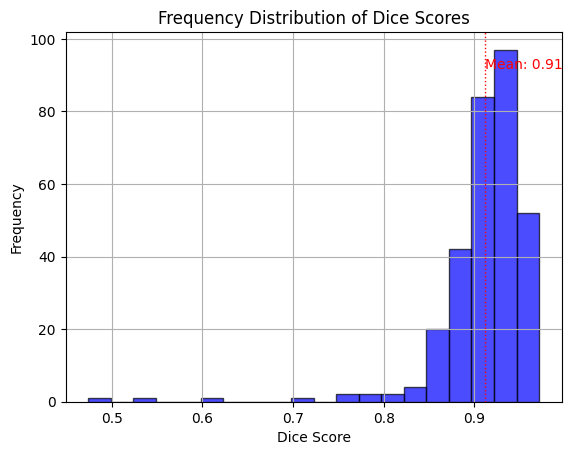

In [ ]:
import matplotlib.pyplot as plt

plt.hist(dice_scores, bins=20, color='blue', edgecolor='black', alpha=0.7)

mean_dice_score = np.mean(dice_scores)

plt.axvline(mean_dice_score, color='red', linestyle='dotted', linewidth=1)
plt.text(mean_dice_score, plt.ylim()[1]*0.9, f'Mean: {mean_dice_score:.2f}', color = 'red')

plt.title('Frequency Distribution of Dice Scores')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

